<a href="https://colab.research.google.com/github/Kzis/shopee-code-league/blob/main/Shopee_Logistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import re

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
df = pd.read_csv("gdrive/My Drive/Shopee/delivery_orders_march.csv")

In [4]:
df.shape

(3176313, 6)

In [5]:
df.rename(columns={'1st_deliver_attempt': 'first_deliver_attempt', '2nd_deliver_attempt': 'second_deliver_attempt'}, inplace=True)


In [6]:
df.head()

,orderid,pick,first_deliver_attempt,second_deliver_attempt,buyeraddress,selleraddress
0,2215676524,1583138397,1.583385e+09,NaN,"Baging ldl BUENAVISTA,PATAG.CAGAYAN Buagsong,c...",Pantranco vill. 417 Warehouse# katipunan 532 (...
1,2219624609,1583309968,1.583463e+09,1.583799e+09,coloma's quzom CASANAS Site1 Masiyan 533A Stol...,"BLDG 210A Moras C42B 2B16,168 church) Complex ..."
2,2220979489,1583306434,1.583460e+09,NaN,"21-O LumangDaan,Capitangan,Abucay,Bataan .Bign...","#66 150-C, DRIVE, Milagros Joe socorro Metro M..."
3,2221066352,1583419016,1.583556e+09,NaN,"616Espiritu MARTINVILLE,MANUYO #5paraiso kengi...","999maII 201,26 Villaruel Barretto gen.t number..."
4,2222478803,1583318305,1.583480e+09,NaN,L042 Summerbreezee1 L2(Balanay analyn Lot760 C...,G66MANILA Hiyas Fitness MAYSILO magdiwang Lt.4...


#Create Instants & Prep Data

In [7]:
public_holidays = ["2020-03-08", "2020-03-25", "2020-03-30", "2020-03-31"]
city_order = ["metro manila", "luzon", "visayas", "mindanao"]
GMT8_OFFSET = 3600 * 8

In [8]:
# Prep datetime
df[["pick", "first_deliver_attempt", "second_deliver_attempt"]] +=GMT8_OFFSET

df["pick"] = pd.to_datetime(df["pick"],unit='s').dt.date

df["first_deliver_attempt"] = pd.to_datetime(df["first_deliver_attempt"],unit='s').dt.date

df["second_deliver_attempt"].fillna(0, inplace = True)
df["second_deliver_attempt"] = pd.to_datetime(df["second_deliver_attempt"],unit='s').dt.date

In [9]:
# text = "217B SURGERY, ROCKWELL,POWERPLANT C/OGIFTIAN PICTURECITY KATOLIKO(DAAN KWATRO. DULAWON CAPITOLINEHILLS YONZON D.B. TUPSAN, IBAYO,ABUCAY,BATAAN 32,KATABI 918-HELICONIA STS.,ORMOC (PHIL-DATA BLK1,LOT3 #10SAMPALOC BLOCK61LOT10, DUPLEX-A 22A11 CAMELLA.FRONTE"
# print(find_city_regex(text))

# tt = df[df["orderid"]==2218922817]["buyeraddress"].values
# print(tt)
# print(find_city_regex(tt[0]))

#Find Origin And Destination

In [10]:
def find_city(address):
    for city in city_order:
        if city.lower() in address.lower():
            return city.lower()

In [11]:
def find_city_regex(address):
  match_city = "TEST"
  for city in city_order:
    result = re.findall(city,address.lower())
    if len(result) > 0 :
      match_city = result[0]
  return match_city


In [12]:
df['origin'] = df['selleraddress'].apply(find_city_regex)
df['destination'] = df['buyeraddress'].apply(find_city_regex)

In [13]:
df.head()

,orderid,pick,first_deliver_attempt,second_deliver_attempt,buyeraddress,selleraddress,origin,destination
0,2215676524,2020-03-02,2020-03-05,1970-01-01,"Baging ldl BUENAVISTA,PATAG.CAGAYAN Buagsong,c...",Pantranco vill. 417 Warehouse# katipunan 532 (...,metro manila,metro manila
1,2219624609,2020-03-04,2020-03-06,2020-03-10,coloma's quzom CASANAS Site1 Masiyan 533A Stol...,"BLDG 210A Moras C42B 2B16,168 church) Complex ...",metro manila,metro manila
2,2220979489,2020-03-04,2020-03-06,1970-01-01,"21-O LumangDaan,Capitangan,Abucay,Bataan .Bign...","#66 150-C, DRIVE, Milagros Joe socorro Metro M...",metro manila,metro manila
3,2221066352,2020-03-05,2020-03-07,1970-01-01,"616Espiritu MARTINVILLE,MANUYO #5paraiso kengi...","999maII 201,26 Villaruel Barretto gen.t number...",metro manila,metro manila
4,2222478803,2020-03-04,2020-03-06,1970-01-01,L042 Summerbreezee1 L2(Balanay analyn Lot760 C...,G66MANILA Hiyas Fitness MAYSILO magdiwang Lt.4...,metro manila,luzon


In [14]:
df.origin.value_counts(dropna = False)

metro manila    3173960
luzon              2353
Name: origin, dtype: int64

In [15]:
df.destination.value_counts(dropna = False)


metro manila    1559099
luzon            805484
visayas          479986
mindanao         331744
Name: destination, dtype: int64

In [16]:
# df.pick.value_counts()

In [17]:
# df.first_deliver_attempt.value_counts()

In [18]:
# df.second_deliver_attempt.value_counts()

#Find Deliver Date

In [19]:
def get_business_date_first(df):
    create_date = str(df['pick'])
    resolve_date = str(df['first_deliver_attempt'])

    create_datetime = datetime.strptime(create_date, '%Y-%m-%d')
    resolve_datetime = datetime.strptime(resolve_date, '%Y-%m-%d')

    business_date = np.busday_count(create_date, resolve_date, holidays=public_holidays, weekmask=[1,1,1,1,1,1,0])

    return business_date  

In [20]:
df['1st_deliver_days'] = df.apply(get_business_date_first, axis=1)

In [21]:
df.head()

,orderid,pick,first_deliver_attempt,second_deliver_attempt,buyeraddress,selleraddress,origin,destination,1st_deliver_days
0,2215676524,2020-03-02,2020-03-05,1970-01-01,"Baging ldl BUENAVISTA,PATAG.CAGAYAN Buagsong,c...",Pantranco vill. 417 Warehouse# katipunan 532 (...,metro manila,metro manila,3
1,2219624609,2020-03-04,2020-03-06,2020-03-10,coloma's quzom CASANAS Site1 Masiyan 533A Stol...,"BLDG 210A Moras C42B 2B16,168 church) Complex ...",metro manila,metro manila,2
2,2220979489,2020-03-04,2020-03-06,1970-01-01,"21-O LumangDaan,Capitangan,Abucay,Bataan .Bign...","#66 150-C, DRIVE, Milagros Joe socorro Metro M...",metro manila,metro manila,2
3,2221066352,2020-03-05,2020-03-07,1970-01-01,"616Espiritu MARTINVILLE,MANUYO #5paraiso kengi...","999maII 201,26 Villaruel Barretto gen.t number...",metro manila,metro manila,2
4,2222478803,2020-03-04,2020-03-06,1970-01-01,L042 Summerbreezee1 L2(Balanay analyn Lot760 C...,G66MANILA Hiyas Fitness MAYSILO magdiwang Lt.4...,metro manila,luzon,2


In [22]:
def get_business_date_second(df):
    create_date = str(df['first_deliver_attempt'])
    resolve_date = str(df['second_deliver_attempt'])
    
    if resolve_date == '1970-01-01':
        resolve_date = create_date

    create_datetime = datetime.strptime(create_date, '%Y-%m-%d')
    resolve_datetime = datetime.strptime(resolve_date, '%Y-%m-%d')

    business_date = np.busday_count(create_date, resolve_date, holidays=public_holidays, weekmask=[1,1,1,1,1,1,0])

    return business_date  

In [23]:
df['2st_deliver_days'] = df.apply(get_business_date_second, axis=1)

In [24]:
df.head()

,orderid,pick,first_deliver_attempt,second_deliver_attempt,buyeraddress,selleraddress,origin,destination,1st_deliver_days,2st_deliver_days
0,2215676524,2020-03-02,2020-03-05,1970-01-01,"Baging ldl BUENAVISTA,PATAG.CAGAYAN Buagsong,c...",Pantranco vill. 417 Warehouse# katipunan 532 (...,metro manila,metro manila,3,0
1,2219624609,2020-03-04,2020-03-06,2020-03-10,coloma's quzom CASANAS Site1 Masiyan 533A Stol...,"BLDG 210A Moras C42B 2B16,168 church) Complex ...",metro manila,metro manila,2,3
2,2220979489,2020-03-04,2020-03-06,1970-01-01,"21-O LumangDaan,Capitangan,Abucay,Bataan .Bign...","#66 150-C, DRIVE, Milagros Joe socorro Metro M...",metro manila,metro manila,2,0
3,2221066352,2020-03-05,2020-03-07,1970-01-01,"616Espiritu MARTINVILLE,MANUYO #5paraiso kengi...","999maII 201,26 Villaruel Barretto gen.t number...",metro manila,metro manila,2,0
4,2222478803,2020-03-04,2020-03-06,1970-01-01,L042 Summerbreezee1 L2(Balanay analyn Lot760 C...,G66MANILA Hiyas Fitness MAYSILO magdiwang Lt.4...,metro manila,luzon,2,0


# Merge SLA

In [25]:
conditions = [
    (df['origin'].str.strip() == "metro manila") & (df['destination'].str.strip() =="metro manila"),
    (df['origin'].str.strip() == "metro manila") & (df['destination'].str.strip() =="luzon"),
    (df['origin'].str.strip() == "metro manila") & (df['destination'].str.strip() =="visayas"),
    (df['origin'].str.strip() == "metro manila") & (df['destination'].str.strip() =="mindanao"),
    (df['origin'].str.strip() == "luzon") & (df['destination'].str.strip() =="metro manila"),
    (df['origin'].str.strip() == "luzon") & (df['destination'].str.strip() =="luzon"),
    (df['origin'].str.strip() == "luzon") & (df['destination'].str.strip() =="visayas"),
    (df['origin'].str.strip() == "luzon") & (df['destination'].str.strip() =="mindanao"),
    (df['origin'].str.strip() == "visayas") & (df['destination'].str.strip() =="metro manila"),
    (df['origin'].str.strip() == "visayas") & (df['destination'].str.strip() =="luzon"),
    (df['origin'].str.strip() == "visayas") & (df['destination'].str.strip() =="visayas"),
    (df['origin'].str.strip() == "visayas") & (df['destination'].str.strip() =="mindanao"),
    (df['origin'].str.strip() == "mindanao") & (df['destination'].str.strip() =="metro manila"),
    (df['origin'].str.strip() == "mindanao") & (df['destination'].str.strip() =="luzon"),
    (df['origin'].str.strip() == "mindanao") & (df['destination'].str.strip() =="visayas"),
    (df['origin'].str.strip() == "mindanao") & (df['destination'].str.strip() =="mindanao")
    ]

values = [3,5,7,7,5,5,7,7,7,7,7,7,7,7,7,7]

In [26]:
df['sla'] = np.select(conditions, values)

In [27]:
df.head()

,orderid,pick,first_deliver_attempt,second_deliver_attempt,buyeraddress,selleraddress,origin,destination,1st_deliver_days,2st_deliver_days,sla
0,2215676524,2020-03-02,2020-03-05,1970-01-01,"Baging ldl BUENAVISTA,PATAG.CAGAYAN Buagsong,c...",Pantranco vill. 417 Warehouse# katipunan 532 (...,metro manila,metro manila,3,0,3
1,2219624609,2020-03-04,2020-03-06,2020-03-10,coloma's quzom CASANAS Site1 Masiyan 533A Stol...,"BLDG 210A Moras C42B 2B16,168 church) Complex ...",metro manila,metro manila,2,3,3
2,2220979489,2020-03-04,2020-03-06,1970-01-01,"21-O LumangDaan,Capitangan,Abucay,Bataan .Bign...","#66 150-C, DRIVE, Milagros Joe socorro Metro M...",metro manila,metro manila,2,0,3
3,2221066352,2020-03-05,2020-03-07,1970-01-01,"616Espiritu MARTINVILLE,MANUYO #5paraiso kengi...","999maII 201,26 Villaruel Barretto gen.t number...",metro manila,metro manila,2,0,3
4,2222478803,2020-03-04,2020-03-06,1970-01-01,L042 Summerbreezee1 L2(Balanay analyn Lot760 C...,G66MANILA Hiyas Fitness MAYSILO magdiwang Lt.4...,metro manila,luzon,2,0,5


#Find Late

In [28]:
df["is_late"] = (df["1st_deliver_days"] > df["sla"]) | (df["2st_deliver_days"] > 3)
df["is_late"] = df["is_late"].astype(int)

In [29]:
df.head()

,orderid,pick,first_deliver_attempt,second_deliver_attempt,buyeraddress,selleraddress,origin,destination,1st_deliver_days,2st_deliver_days,sla,is_late
0,2215676524,2020-03-02,2020-03-05,1970-01-01,"Baging ldl BUENAVISTA,PATAG.CAGAYAN Buagsong,c...",Pantranco vill. 417 Warehouse# katipunan 532 (...,metro manila,metro manila,3,0,3,0
1,2219624609,2020-03-04,2020-03-06,2020-03-10,coloma's quzom CASANAS Site1 Masiyan 533A Stol...,"BLDG 210A Moras C42B 2B16,168 church) Complex ...",metro manila,metro manila,2,3,3,0
2,2220979489,2020-03-04,2020-03-06,1970-01-01,"21-O LumangDaan,Capitangan,Abucay,Bataan .Bign...","#66 150-C, DRIVE, Milagros Joe socorro Metro M...",metro manila,metro manila,2,0,3,0
3,2221066352,2020-03-05,2020-03-07,1970-01-01,"616Espiritu MARTINVILLE,MANUYO #5paraiso kengi...","999maII 201,26 Villaruel Barretto gen.t number...",metro manila,metro manila,2,0,3,0
4,2222478803,2020-03-04,2020-03-06,1970-01-01,L042 Summerbreezee1 L2(Balanay analyn Lot760 C...,G66MANILA Hiyas Fitness MAYSILO magdiwang Lt.4...,metro manila,luzon,2,0,5,0


In [30]:
df.is_late.value_counts()

0    2414175
1     762138
Name: is_late, dtype: int64

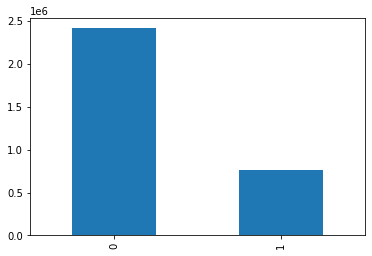

In [31]:
df.is_late.value_counts(sort=False).plot(kind="bar")

# Summission Data

In [32]:
submission = df[["orderid","is_late"]]

In [33]:
submission.head()

,orderid,is_late
0,2215676524,0
1,2219624609,0
2,2220979489,0
3,2221066352,0
4,2222478803,0


In [34]:
submission.to_csv("submission.csv", index = False)